# Image classification using LoRA with Vision Transformers

## Introduction

Dalam notebook ini, kita akan mempelajari cara menggunakan [LoRA](https://arxiv.org/abs/2106.09685) dari 🤗 PEFT untuk *fine-tune* model klasifikasi gambar dengan HANYA menggunakan **0,72%** dari parameter yang dapat dilatih pada model aslinya.

LoRA menambahkan "matriks pembaruan" bertingkat rendah (*low-rank update matrices*) pada blok tertentu dalam model dasar (dalam kasus ini, blok perhatian) dan HANYA melatih matriks-matriks tersebut selama proses *fine-tuning*. Saat *inference*, matriks pembaruan ini akan digabungkan (*merged*) dengan parameter model asli. Untuk detail lebih lanjut, silakan lihat [makalah asli LoRA](https://arxiv.org/abs/2106.09685).

**Catatan:** Notebook ini dibangun berdasarkan [notebook klasifikasi gambar dengan LoRA](https://huggingface.co/docs/peft/task_guides/image_classification_lora).

##What is LoRA

**LoRA (Low-rank Optimization for Rapid Adaptation)** adalah metode pelatihan yang efisien dalam penggunaan parameter, yang memanfaatkan dekomposisi bertingkat rendah (*low-rank decomposition*) untuk mengurangi jumlah parameter yang dilatih. Alih-alih memperbarui seluruh matriks bobot, LoRA menggunakan matriks kecil yang beradaptasi dengan data baru sambil mempertahankan matriks bobot asli.

Untuk mengimplementasikan LoRA, langkah pertama adalah membekukan bobot model pra-terlatih, kemudian menambahkan matriks dekomposisi bertingkat rendah yang dapat dilatih ke setiap lapisan dalam arsitektur transformer. Matriks ini jauh lebih kecil dibandingkan bobot asli dan mampu menangkap informasi penting untuk adaptasi. Dengan mengalikan matriks dekomposisi ini dengan bobot yang dibekukan, kita mendapatkan aproksimasi bertingkat rendah dari bobot model yang telah diadaptasi. Dengan cara ini, jumlah parameter yang dilatih dapat dikurangi secara signifikan, sekaligus menghemat memori GPU dan waktu *inference*.

Sebagai contoh, misalkan kita memiliki model pra-terlatih dengan 100 juta parameter dan 50 lapisan, dan ingin melakukan *fine-tuning*. Dengan LoRA, kita dapat menambahkan dua matriks dekomposisi bertingkat rendah berukuran 100 x 10 dan 10 x 100 ke setiap lapisan model. Dengan mengalikan matriks-matriks ini dengan bobot yang dibekukan, kita mendapatkan aproksimasi bertingkat rendah dari bobot model yang diadaptasi hanya dengan 2000 parameter per lapisan. Artinya, jumlah parameter yang dilatih dapat dikurangi dari 100 juta menjadi 2 juta, atau 50 kali lebih hemat. Selain itu, proses *inference* juga dapat dipercepat dengan menggunakan aproksimasi bertingkat rendah tersebut.

Pendekatan ini menawarkan beberapa keuntungan:
1. **Pengurangan Parameter yang Dilatih**: LoRA secara signifikan mengurangi jumlah parameter yang dilatih, memungkinkan pelatihan yang lebih cepat dan penggunaan memori yang lebih rendah.
2. **Bobot Pra-terlatih Dibekukan**: Matriks bobot asli tetap dibekukan, memungkinkan penggunaannya sebagai dasar untuk berbagai model LoRA yang ringan. Hal ini mempermudah transfer learning dan adaptasi domain.
3. **Kompatibilitas dengan Metode Parameter-Efisien Lain**: LoRA dapat digabungkan dengan teknik parameter-efisien lainnya, seperti *knowledge distillation* dan *pruning*, untuk meningkatkan efisiensi model lebih lanjut.
4. **Performa yang Setara**: LoRA mencapai performa yang sebanding dengan model yang di-*fine-tune* sepenuhnya, membuktikan efektivitasnya dalam mempertahankan akurasi meskipun jumlah parameter yang dilatih dikurangi.


Mari kita mulai dengan menginstal dependensi.


## Imports
---

In [ ]:
%%capture
!pip install datasets
!pip install evaluate
!pip install accelerate -U
!pip install peft

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from datasets import load_dataset
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate

## Authentication

Kita akan membagikan model yang telah di-*fine-tune* setelah proses pelatihan selesai. Untuk itu, kita perlu melakukan autentikasi menggunakan token 🤗 kita. Token ini tersedia di [sini](https://huggingface.co/settings/tokens). Jika Anda belum memiliki akun 🤗, kami sangat menyarankan Anda untuk membuatnya; pendaftarannya gratis!





In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the Dataset
---

- Kita akan menggunakan [Oxford-IIIT Pets Dataset](https://huggingface.co/datasets/pcuenq/oxford-pets).  
- Dataset ini merupakan kumpulan gambar dari 37 jenis ras kucing dan anjing yang berbeda.

In [ ]:
dataset = load_dataset('pcuenq/oxford-pets')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

(…)-00000-of-00001-ecc2afb43dedd5e0.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

Dataset ini memiliki fitur-fitur berikut:  

- **path**: Jalur ke file gambar.  
- **label**: Jenis ras dari hewan.  
- **dog**: Menunjukkan apakah hewan tersebut adalah anjing atau bukan.  
- **image**: Gambar dalam format **PIL Image**.  

In [ ]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01Y\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

Mari kita periksa kelas-kelasnya

In [ ]:
classes = dataset['train'].unique('label')
print(len(classes),classes)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


#### Let's see some sample images from the dataset.

TypeError: Image data of dtype object cannot be converted to float

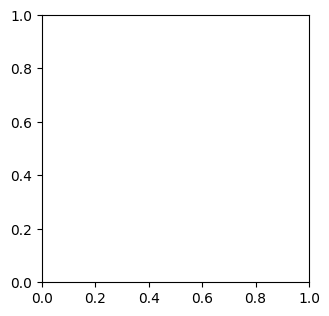

In [ ]:
def show_samples(ds,rows=2,cols=4):
    samples = ds.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing
---

Pada bagian ini, kita memastikan bahwa dataset telah diformat, ditransformasikan, dan siap untuk digunakan dalam model ViT untuk pelatihan. Bagian ini mencakup langkah-langkah pemuatan data, eksplorasi, pembagian, dan transformasi yang diperlukan untuk mendukung pelatihan dan evaluasi model klasifikasi gambar secara efisien menggunakan metode LoRA.

Mari kita mulai dengan membagi dataset menjadi `train` untuk pelatihan dan `test` untuk evaluasi.

In [ ]:
dataset = dataset['train'].train_test_split(train_size=0.8)
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1478
    })
})

Untuk mempersiapkan input bagi model, kita perlu menerapkan transformasi yang diperlukan. Hal ini dapat dilakukan dengan memanfaatkan modul `AutoImageProcessor`, yang memuat transformasi sesuai dengan model yang relevan. Kita dapat melihat transformasi apa saja yang digunakan dalam konfigurasi prosesor.

In [ ]:
model_name = "vit-base-patch16-224"
model_checkpoint = f"google/{model_name}"

processor = AutoImageProcessor.from_pretrained(model_checkpoint)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Kita juga akan memetakan nama label ke indeks menggunakan `label2id` dan `id2label`, sehingga lebih mudah untuk dibaca.

In [ ]:
label2id = {c:idx for idx,c in enumerate(classes)}
id2label = {idx:c for idx,c in enumerate(classes)}

Kita dapat membuat sebuah fungsi untuk melakukan prapemrosesan pada batch. Fungsi ini akan dipanggil oleh trainer saat kita menambahkannya ke dataset menggunakan `with_transform` selama waktu pelatihan.

Dalam fungsi `transforms` ini, kita melakukan hal berikut:

- Mungkin ada beberapa gambar dalam dataset Anda yang berupa grayscale atau transparan (RGBA). Untuk menghindari kesalahan dimensi, lebih aman mengonversinya ke format RGB menggunakan metode konversi PIL.
- Kita melewatkan gambar melalui processor untuk menerapkan transformasi guna memproses dan mengonversinya ke dalam format PyTorch.
- Dengan menggunakan `label2id`, kita mengonversi label string menjadi representasi integernya.

In [ ]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor([x for x in batch['image']],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [ ]:
dataset = dataset.with_transform(transforms)

Kita juga membuat fungsi `collate_fn` untuk mendefinisikan cara menggabungkan sampel individual yang diambil dari dataset menjadi batch. `collate_fn` digunakan saat iterasi melalui dataset dalam loop pelatihan untuk mempersiapkan batch data yang dapat diberikan ke model.

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Metric
---

Kita dapat menggunakan pustaka [evaluate](https://huggingface.co/docs/evaluate/index) dari Hugging Face untuk menghitung metrik. Untuk klasifikasi gambar, kita dapat menggunakan metrik akurasi.

In [ ]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

Sebelum memuat model, mari kita definisikan fungsi pembantu untuk memeriksa total jumlah parameter yang dimiliki model, serta berapa banyak dari parameter tersebut yang dapat dilatih.

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

## Model

The Vision Transformer (ViT) model represents a significant innovation in computer vision tasks, departing from the conventional convolutional neural network (CNN) architecture. It applies the Transformer architecture, originally designed for natural language processing (NLP), directly to image data without relying on CNNs.

ViT processes images by splitting them into sequences of fixed-size non-overlapping patches, linearly embedding these patches, adding absolute position embeddings, and then feeding this sequence of vectors into a standard Transformer encoder. A special token, often referred to as the [CLS] token, is added to serve as the representation of the entire image, allowing for image classification.

To load our pre-trained ViT model, we will use ViTForImageClassification class. We will do that by passing in num_labels argument along with our label mappings id2label and label2id. We also need to pass ignore_mismatched_sizes = True to compensate for the change in number of parameters in the classifier layer.

translate'

BLACKBOXAI

Model Vision Transformer (ViT) merupakan inovasi signifikan dalam tugas-tugas visi komputer, yang berbeda dari arsitektur jaringan saraf konvolusional (CNN) konvensional. Model ini menerapkan arsitektur Transformer, yang awalnya dirancang untuk pemrosesan bahasa alami (NLP), secara langsung pada data gambar tanpa bergantung pada CNN.

ViT memproses gambar dengan membaginya menjadi urutan patch non-overlapping berukuran tetap, mengembedding patch ini secara linier, menambahkan embedding posisi absolut, dan kemudian memberi urutan vektor ini ke dalam encoder Transformer standar. Sebuah token khusus, yang sering disebut sebagai token [CLS], ditambahkan untuk berfungsi sebagai representasi dari seluruh gambar, memungkinkan untuk klasifikasi gambar.

Untuk memuat model ViT yang telah dilatih sebelumnya, kita akan menggunakan kelas ViTForImageClassification. Kita akan melakukannya dengan memberikan argumen num_labels bersama dengan pemetaan label id2label dan label2id kita. Kita juga perlu memberikan ignore_mismatched_sizes = True untuk mengkompensasi perubahan jumlah parameter di lapisan klasifikator.

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
print_trainable_parameters(model)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85827109 || all params: 85827109 || trainable%: 100.00


Selanjutnya, kita menggunakan get_peft_model untuk membungkus model dasar sehingga matriks "update" ditambahkan ke tempat yang sesuai.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 618277 || all params: 86445386 || trainable%: 0.72


### Let's examine the LoraConfig Parameters:
- `r`: The rank of the update matrices, represented as an integer. Lower rank values result in smaller update matrices with fewer trainable parameters.

- `target_modules`: The modules (such as attention blocks) where the LoRA update matrices should be applied.

- `alpha`: The scaling factor for LoRA.

- `layers_pattern`: A pattern used to match layer names in `target_modules` if `layers_to_transform` is specified. By default, Peft model will use a common layer pattern (layers, h, blocks, etc.). This pattern can also be used for exotic and custom models.

- `rank_pattern`: A mapping from layer names or regular expression expressions to ranks that differ from the default rank specified by `r`.

- `alpha_pattern`: A mapping from layer names or regular expression expressions to alphas that differ from the default alpha specified by `lora_alpha`.

#### Here's our model architecture

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=768, bias=False)
                )
                (lora_embedding_A): ParameterDict


### Let's look at the components of the LoRA model:

- **lora.Linear**: LoRA adapts pre-trained models using a low-rank decomposition. It modifies the linear transformation layers (query, key, value) in the attention mechanism.
  - **base_layer**: The original linear transformation.
  - **lora_dropout**: Dropout applied to the LoRA parameters.
  - **lora_A**: The matrix A in the low-rank decomposition.
  - **lora_B**: The matrix B in the low-rank decomposition.
  - **lora_embedding_A/B**: The learnable embeddings for LoRA.

# Training
---

We'll use HuggingFace Trainer to train our model, we can set our desired training arguments and start the training.

In [ ]:
batch_size = 128

args = TrainingArguments(
    f"{model_checkpoint}-finetuned-lora-oxford-pets",
    per_device_train_batch_size=batch_size,
    learning_rate=5e-3,
    num_train_epochs=5,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    report_to='tensorboard',
    fp16=True,
    push_to_hub=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Some things to note here:

* We're using a larger batch size since there is only a handful of parameters to train.
* Larger learning rate than the normal (1e-5 for example).

All of these things are a byproduct of the fact that we're training only a small number of parameters. This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments.

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor
)

<ipython-input-23-8c068540df0c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


HfHubHTTPError: (Request ID: Root=1-6778d2a1-348e34c9008bfc5271bb251d;cecce435-eecf-48da-baaf-fd93aa391add)

403 Forbidden: You don't have the rights to create a model under the namespace "anitaa27".
Cannot access content at: https://huggingface.co/api/repos/create.
Make sure your token has the correct permissions.

In [ ]:
trainer.train()

## Sharing your model and inference

Once the fine-tuning is done, we can share the LoRA parameters with the community like so:

In [ ]:
repo_name = f"alanahmet/{model_name}-finetuned-lora-oxfordPets"
lora_model.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

HfHubHTTPError: (Request ID: Root=1-6778d2a7-7d9bb78c53852b930a446102;657c1e49-9671-4de1-9702-127fdd166153)

403 Forbidden: Authorization error..
Cannot access content at: https://huggingface.co/alanahmet/vit-base-patch16-224-finetuned-lora-oxfordPets.git/info/lfs/objects/batch.
Make sure your token has the correct permissions.

When we call `push_to_hub()` on the `lora_model`, only the LoRA parameters along with any modules specified in `modules_to_save` are saved. If we take a look at the [trained LoRA parameters](https://huggingface.co/alanahmet/vit-base-patch16-224-finetuned-lora-oxfordPets/blob/main/adapter_model.safetensors), we see that it's only **2.48 MB**! This greatly helps with portability especially when we're using a very large model to fine-tune.

Next, we see how to load the LoRA updated parameters along with our base model for inference. When we wrap a base model with `PeftModel` that modifications are DONE in place. So to mitigate any concerns that might stem from in place modifications, we newly initialize our base model just like we did earlier and construct our inference model.

In [ ]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

adapter_config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

And let's now fetch a sample for inference.

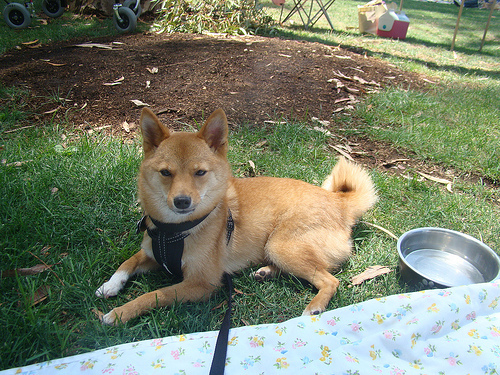

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/alanahmet/LoRA-pets-dataset/resolve/main/shiba_inu_136.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

We first instantiate an `image_processor` from the underlying model repo.

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


We then prepare the sample for inference.

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


And run inference!

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: shiba inu


# **Conclusion**

In this tutorial, we've explored LoRA (Low-rank Optimization for Rapid Adaptation), a parameter-efficient training methodology that significantly reduces the number of trainable parameters while preserving model accuracy. By utilizing low-rank decomposition, LoRA enables the adaptation of pre-trained models to new data by employing smaller matrices to capture essential information.

Key takeaways from this tutorial include:

1. **Parameter Efficiency**: LoRA reduces the number of trainable parameters, leading to faster training, reduced memory consumption, and improved efficiency in model adaptation.
2. **Adaptation Methodology**: The utilization of rank decomposition matrices inserted into specific layers of the model allows for rapid adaptation to new data while maintaining the original model's foundational knowledge.
3. **Model Performance**: Despite the reduction in trainable parameters, LoRA demonstrates comparable performance to fully fine-tuned models, showcasing its effectiveness in preserving accuracy.

Through step-by-step implementation, we've fine-tuned an image classification model using LoRA. We've covered dataset preparation, model loading, training, and sharing of the LoRA-updated parameters with the wider community.

The ability to efficiently adapt pre-trained models using LoRA provides a powerful approach for practitioners in various domains, allowing for quick adaptation to new data while ensuring resource efficiency and maintaining high model performance.

For further exploration of LoRA in various applications, we encourage further reading of the original LoRA paper and check the available resources provided by Hugging Face.

For more information about LoRA you can check:


*   [Hugging Face Image Classification using LoRA](https://huggingface.co/docs/peft/task_guides/image_classification_lora)
*   [CONCEPTUAL LoRA GUIDE](https://huggingface.co/docs/peft/conceptual_guides/lora)
*   [Computer Vision Course Image Classification with Transer Learning](https://github.com/shreydan/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/transfer-learning.ipynb)
*   [LoRA Paper](https://arxiv.org/abs/2106.09685)